# Pileup Plots

Integrative analysis across peak sets and datasets.

**Inputs:**
1. List of peak sets
2. Config of samples, bigwig path and class of sample (each class will have same plot styling). If sample belongs to ATAC dataset, old cluster ID else NA.
3. For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)

In [1]:
library(ggplot2)
library(patchwork)
library(reshape2)
library(rtracklayer)
library(scales)
library(viridis)
library(matrixStats)
library(raster)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vecto

## Loading Inputs

### Configs

In [5]:
vortex_config = read.table("./vortex_tracks_config.tsv", sep='\t', header=T, stringsAsFactors = F)
vortex_config$type = factor(vortex_config$type)
vortex_config

title,short_name,old_cluster,type,group,width,path
<chr>,<chr>,<int>,<fct>,<int>,<int>,<chr>
Fibroblast,Fib,1,ATAC,1,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx1/signal/rep1/cluster_idx1.fc.signal.bigwig
D1M Low OSK,D1M-L,NA,ATAC,2,2000,/srv/scratch/surag/scMultiome-reprog/clusters/20220612_n13525/croo/D1M.c15/signal/rep1/D1M.c15.fc.signal.bigwig
D1M High OSK,D1M-H,NA,ATAC,2,2000,/srv/scratch/surag/scMultiome-reprog/clusters/20220612_n13525/croo/D1M.c11/signal/rep1/D1M.c11.fc.signal.bigwig
D2M Low OSK,D2M-L,NA,ATAC,3,2000,/srv/scratch/surag/scMultiome-reprog/clusters/20220612_n13525/croo/D2M.c15/signal/rep1/D2M.c15.fc.signal.bigwig
D2M High OSK,D2M-H,NA,ATAC,3,2000,/srv/scratch/surag/scMultiome-reprog/clusters/20220612_n13525/croo/D2M.c11/signal/rep1/D2M.c11.fc.signal.bigwig
iPSC,iPSC,8,ATAC,4,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx8/signal/rep1/cluster_idx8.fc.signal.bigwig


In [6]:
peak_set_config = read.table("./vortex_peak_set_config.tsv", stringsAsFactors = F, comment.char = '', sep='\t', header=T)
peak_set_config

title,group,path
<chr>,<int>,<chr>
P1,1,/users/surag/kundajelab/scATAC-reprog/src/analysis/20200307_fine_clustering/beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx1.bed
P2,1,/users/surag/kundajelab/scATAC-reprog/src/analysis/20200307_fine_clustering/beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx2.bed
P6,1,/users/surag/kundajelab/scATAC-reprog/src/analysis/20200307_fine_clustering/beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx6.bed
P7,1,/users/surag/kundajelab/scATAC-reprog/src/analysis/20200307_fine_clustering/beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx7.bed
P8,1,/users/surag/kundajelab/scATAC-reprog/src/analysis/20200307_fine_clustering/beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx8.bed
E-ON,1,/users/surag/kundajelab/scATAC-reprog/src/figures_factory/Fig5/early_on.bed


In [7]:
cluster_config = read.table("../../figures_factory/configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

rownames(cluster_config) = cluster_config$cluster
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#B03743,Fibroblast,1
2,2,#E85F6D,Fibroblast-like,3
3,3,#7C2730,Fibroblast-like,2
4,4,#F0A118,Intermediate,12
5,5,#78A824,Pre-iPSC,13
6,6,#A6D854,Pre-iPSC,14
7,7,#F01D35,Fibroblast-like,5
8,8,#13C4A3,iPSC,15
9,9,#406614,Partially-reprogrammed,10


### Peak Sets

In [8]:
peak_sets = list()
SUBSAMPLE = 25

for (i in seq(nrow(peak_set_config))) {
    peak_sets[[i]] = import(peak_set_config[i, "path"])
    peak_sets[[i]] = peak_sets[[i]][seq(1,length(peak_sets[[i]]),SUBSAMPLE)]
}

In [9]:
# manually load peaks
# peak_sets = list()
# peak_sets[[1]] = import("/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/TFAP2C.dependent.reg.elements.hg38.bed")
# peak_sets[[1]] = peak_sets[[1]][seq(1,length(peak_sets[[1]]),5)]

# peak_sets[[2]] = import("/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/naive.specific.atac.hg38.bed")
# peak_sets[[2]] = peak_sets[[2]][seq(1,length(peak_sets[[2]]),5)]

# peak_sets[[3]] = import("/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/primed.specific.atac.hg38.bed")
# peak_sets[[3]] = peak_sets[[3]][seq(1,length(peak_sets[[3]]),5)]

In [10]:
peak_set_lens = list()

for (i in seq(length(peak_sets))) {
    peak_set_lens[[i]] = length(peak_sets[[i]])
}

peak_set_lens

sum(unlist(peak_set_lens))

[[1]]
[1] 1561

[[2]]
[1] 2058

[[3]]
[1] 1209

[[4]]
[1] 940

[[5]]
[1] 1102

[[6]]
[1] 345

[1] 7215

### Fetch Data from BigWigs

In [11]:
get_matrix_from_bigwig <- function(bigwig_path, peak_set) {
    # ensure peak set has fixed width
    stopifnot(length(unique(width(peak_set)))==1)
    
    as.matrix(import(bigwig_path, 
      which=peak_set, as="NumericList"))
}

In [12]:
matrices = list()

In [14]:
for (i in seq(length(peak_sets))) {
    matrices[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        matrices[[i]][[j]] = get_matrix_from_bigwig(vortex_config[j, "path"], 
                                                    resize(peak_sets[[i]], width=vortex_config[j, "width"], fix='center'))
    }
}

## Compute Orders for Each Peak Set and Reorder

In [15]:
# samples which will be used to decide peak order (based on mean signal across all)
ROW_ORDER_TYPE = "ATAC"

In [16]:
peak_set_orders = list()

In [17]:
for (i in seq(length(peak_sets))) {
    tmp_matrix = do.call(cbind, matrices[[i]][vortex_config$type %in% ROW_ORDER_TYPE])
    peak_set_orders[[i]] = order(rowSums(tmp_matrix))
}

In [18]:
rm(tmp_matrix)

In [19]:
peak_set_orders[[1]][1:10]

[1]  701 1002   60  910 1122 1508  638  946  599  855

In [20]:
for (i in seq(length(peak_sets))) {
    for (j in seq(nrow(vortex_config))) {
        matrices[[i]][[j]] = matrices[[i]][[j]][peak_set_orders[[i]], ]
    }
}

## Smooth Samples

In [21]:
y_lims = list()

In [22]:
# find limits for clipping
for (k in seq(length(unique(vortex_config$type)))) {
    type = unique(vortex_config$type)[k]
    
    tmp_matrices = list()
    
    # collapse across time points
    for (i in seq(length(peak_sets))) {
        tmp_matrices[[i]] = do.call(cbind, matrices[[i]][vortex_config$type %in% type])
    }
    
    # collapse across peak sets
    tmp_matrices = do.call(rbind, tmp_matrices)    
    
    y_lims[[type]] = as.numeric(quantile(tmp_matrices, 0.99))
    
}

In [23]:
rm(tmp_matrices)

In [24]:
y_lims

[[1]]
[1] 11.64443

In [25]:
# clip matrices to y_lim
clipped_matrices = list()

for (i in seq(length(peak_sets))) {
    clipped_matrices[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        clipped_matrices[[i]][[j]] = matrices[[i]][[j]]
        clipped_matrices[[i]][[j]][clipped_matrices[[i]][[j]] > y_lims[[vortex_config[j, "type"]]]] = y_lims[[vortex_config[j, "type"]]]
    }
}

In [32]:
# collapse and trim if required

TRIM_TO = 1000

avg_fcs_vectors = list()

for (i in seq(length(peak_sets))) {
    avg_fcs_vectors[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        avg_fcs_vectors[[i]][[j]] = colMeans(clipped_matrices[[i]][[j]])
        avg_fcs_vectors[[i]][[j]] = avg_fcs_vectors[[i]][[j]][as.integer((length(avg_fcs_vectors[[i]][[j]]) - TRIM_TO)/2):as.integer((length(avg_fcs_vectors[[i]][[j]]) + TRIM_TO)/2)]
    }
}

## Decide Limits and Colour Schemes

In [55]:
ymax_lims = list()
# decide limits for each type
for (k in seq(length(unique(vortex_config$type)))) {
    type = unique(vortex_config$type)[k]
    
    tmp_vecs = list()
    
    # collapse across time points
    for (i in seq(length(peak_sets))) {
        tmp_vecs[[i]] = do.call(cbind, avg_fcs_vectors[[i]][vortex_config$type %in% type])
    }
    
    # collapse across peak sets
    tmp_vecs = do.call(rbind, tmp_vecs)
    
    high = max(tmp_vecs)
    
    ymax_lims[[k]] = high + 1
    
}

In [56]:
ymax_lims

[[1]]
[1] 9.051316

In [157]:
plot_fcs <- function(vec, ymax_lim,
                       title=NULL, clust_name=NULL, xticks=NULL, yticks=NULL) {
    # ticks is a number and if not null, will make ticks at
    # left and right end with +ticks kb and -ticks kb
    
    df = data.frame(y=vec,
                   x=seq(length(vec)))
    
    plot <- ggplot(df, aes(x=x, y= y)) +
#     geom_tile_rast() + # kinda slow, geom_raster is faster and smaller files
#     geom_tile() +
    geom_line() +
    coord_cartesian(ylim=c(0,ymax_lim)) +
    scale_y_continuous(expand = c(0, 0)) + # this removes whitespace between plot and border
    theme_void() 
    
    if (!is.null(title)) {
        plot = plot + ggtitle(title) +
        theme(plot.title = element_text(hjust = 0.5))
    }
    
    if (!is.null(clust_name)) {
        plot = plot + ylab(sprintf("%s ", clust_name)) + 
             theme(axis.title.y = element_text())
    }
    
    if (!is.null(xticks)) {
        plot = plot + scale_x_continuous(breaks = c(1, ncol(bwmatrix)/2, ncol(bwmatrix)), 
                                         labels = c(sprintf("-%dkb", ticks), "",
                                                    sprintf("+%dkb", ticks)),
                                         expand = c(0,0)) # this removes whitespace between plot and border
        plot = plot + theme(axis.ticks.length.x=unit(.25, "cm"),
                           axis.text.x = element_text(size=10))
    }
                                         
    else {
        plot = plot + 
               scale_x_continuous(expand=c(0,0)) + # this removes whitespace between plot and border
               theme(axis.ticks.x=element_blank(),
                    axis.text.x = element_blank(),) 
    }
    
    if (!is.null(yticks)) {
        plot = plot + theme(axis.ticks.length.y=unit(.25, "cm"),
                            axis.ticks.y = element_line(colour = "black", size = .5),
                           axis.text.y = element_text(size=10))
    }
    
    else {
        plot = plot + theme(axis.ticks.y=element_blank())
    }
    
    plot = plot + theme(legend.position = "none",             
            axis.title.x = element_blank(),
#             axis.text.y=element_blank(),
            axis.line=element_blank(),
            plot.margin = unit(c(0,2,0,2), "pt"), # right tick label was clipping
          panel.border = element_rect(colour = "black", fill=NA, size=0.5))
    
    plot
}

In [158]:
all_plots = list()
row_widths = list()

In [159]:
X_SPACER_WIDTH = 0
X_NON_SPACER_WIDTH = -0.15

for (i in seq(length(peak_sets))) {
    tot_plots = 1
    all_plots[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        if (j>1) {
            all_plots[[i]][[tot_plots]] = plot_spacer() # spacing between every consecutive plot
            
            if (vortex_config[j,"group"]!=vortex_config[j-1,"group"]) {
            row_widths[[tot_plots]] = X_SPACER_WIDTH # spacing between groups
            }
            else {
                row_widths[[tot_plots]] = X_NON_SPACER_WIDTH # spacing within groups
            }
            
            tot_plots = tot_plots + 1
        }
        
        title = NULL
        ticks = NULL
        yticks = NULL
        clust_name = NULL
        if (i==1) {
            title = vortex_config[j, "short_name"]
        }
        
        if (j==1) {
            clust_name = peak_set_config$title[i]
        }
        
        if ((i==1)&&(j==1)) {
            yticks = T
        }
        # TODO: ticks mess margins
#         else if (i==length(peak_sets)) {
#             ticks = vortex_config[j, "width"]/2000
#         }
        
        all_plots[[i]][[tot_plots]] = plot_fcs(avg_fcs_vectors[[i]][[j]],
                                         ymax_lims[[as.numeric(vortex_config[j, "type"])]],
                                                 title=title,
                                                 clust_name=clust_name,
                                                 xticks=ticks,
                                              yticks=yticks)
        row_widths[[tot_plots]] = 1
        tot_plots = tot_plots + 1
    }
}

In [160]:
Y_SPACER_WIDTH = -0.2
Y_NON_SPACER_WIDTH = -0.3

rowwise_plots = list()
col_heights = list()
tot_plots = 1

for (i in seq(length(peak_sets))) {
    if (i>1) {
        rowwise_plots[[tot_plots]] = plot_spacer() # spacing between groups
        
        if (peak_set_config[i,"group"]!=peak_set_config[i-1,"group"]) {
            col_heights[[tot_plots]] = Y_SPACER_WIDTH*mean(unlist(peak_set_lens)) # spacing between groups
        }
        else {
            col_heights[[tot_plots]] = Y_NON_SPACER_WIDTH*mean(unlist(peak_set_lens)) # spacing within groups
        }
        
        tot_plots = tot_plots + 1
    }
    
    rowwise_plots[[tot_plots]] =  wrap_plots(all_plots[[i]], nrow = 1, widths = row_widths)
    col_heights[[tot_plots]] = peak_set_lens[[1]]
    
    tot_plots = tot_plots + 1
}

In [161]:
length(row_widths)
length(col_heights)

[1] 11

[1] 11

In [162]:
length(all_plots[[1]])
length(rowwise_plots)
# length(all_plots[[2]])

[1] 11

[1] 11

### Assemble Integration

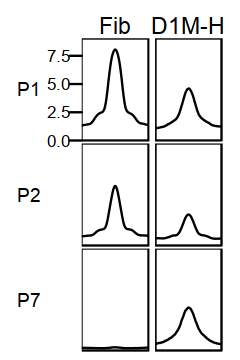

In [163]:
options(repr.plot.width = 2, repr.plot.height = 3)

wrap_plots(wrap_plots(all_plots[[1]][[1]],all_plots[[1]][[5]],nrow=1),
           plot_spacer(),
           wrap_plots(all_plots[[2]][[1]],all_plots[[2]][[3]],nrow=1),
           plot_spacer(),
           wrap_plots(all_plots[[4]][[1]],all_plots[[4]][[3]],nrow=1)
           , ncol=1, heights=c(1,-0.15,1,-0.15,1)) 

In [164]:
top_annotate_plot = ggplot() + 
                theme_void() +
                geom_line() +
                coord_cartesian(xlim = c(0.5,9.5), # this let's use 0-10 on x axis to place items
                               ylim=c(0,10)) + # this let's use 0-10 on y axis to place items
                annotate("segment", x = 0, xend = 1.7, y = 2, yend = 2, size=1, colour = "black") +
                annotate("text", x = .85, y = 5, size=5, label = "Fibroblasts") +

                annotate("segment", x = 1.8, xend = 5.0, y = 2, yend = 2, size=1, colour = "black") +
                annotate("text", x = 3.4, y = 5, size=5, label = "D1") +

                annotate("segment", x = 5.1, xend = 8.3, y = 2, yend = 2, size=1, colour = "black") +
                annotate("text", x = 6.7, y = 5, size=5, label = "D2") +

                annotate("segment", x = 8.4, xend = 10, y = 2, yend = 2, size=1, colour = "black")  +
                annotate("text", x = 9.2, y = 5, size=5, label = "iPSC") 
#                 annotate("text", x = 2, y = 25, label = "Some text")

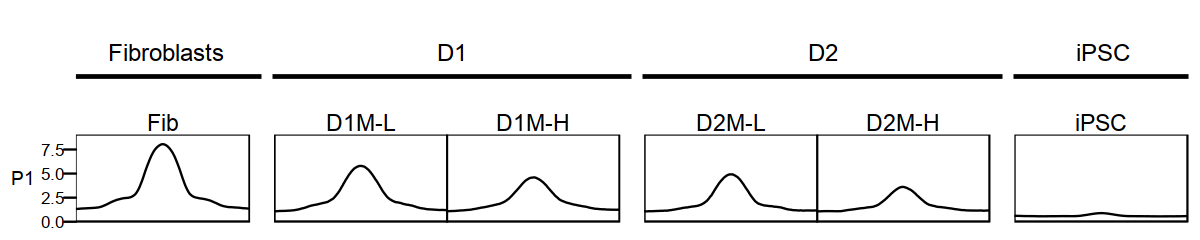

In [165]:
options(repr.plot.width = 10, repr.plot.height = 2)

wrap_plots(top_annotate_plot,
           rowwise_plots[[1]],
           heights=c(1,1))

In [166]:
# left_annotate_plot = ggplot() + 
#                 theme_void() +
#                 geom_line() +
#                 coord_cartesian(xlim = c(0.5,9.5), # this let's use 0-10 on x axis to place items
#                                ylim=c(0.5,9.5)) + # this let's use 0-10 on y axis to place items
#                 annotate("segment", x = 8, xend = 8, y = 0, yend = 2.7, size=1, colour = "black") +
#                 annotate("text", x = 5, y =1.35, size=5, angle=90, label = "Close Open") +

#                 annotate("segment", x = 8, xend = 8, y = 2.8, yend = 6.6, size=1, colour = "black") +
#                 annotate("text", x = 5, y = 4.7, size=5, angle=90, label = "Transient") +

#                 annotate("segment", x = 8, xend = 8, y = 6.7, yend = 10, size=1, colour = "black")  +
#                 annotate("text", x = 5, y = 8.35, size=5, angle=90, label = "Open Close") 
# #                 annotate("text", x = 2, y = 25, label = "Some text")

In [167]:

# options(repr.plot.width = 2, repr.plot.height = 10.5)


# first_col = list()
# for (j in seq(length(rowwise_plots))) {
#    if ("spacer" %in% class(rowwise_plots[[j]])) {
#       first_col[[j]] = plot_spacer()
#    }
#    else {
#        first_col[[j]] = rowwise_plots[[j]][[1]]    
#     }
# }
# first_col_plot = wrap_plots(first_col, 
#                            heights=col_heights)

# wrap_plots(left_annotate_plot,
#            first_col_plot,
#            widths=c(1,1))

In [168]:
# options(repr.plot.width = 13, repr.plot.height = 9)
# vortex_grid = wrap_plots(
#     rowwise_plots,
#     ncol=1,
#     heights = col_heights)

# vortex_grid_w_left_anno = wrap_plots(left_annotate_plot, 
#                                      vortex_grid,
#                                     widths=c(1,12))

# top_annotate_plot_w_space = wrap_plots(plot_spacer(),
#                                        top_annotate_plot,
#                                       widths=c(1,9)) # adjust to account for cluster numbers text

# complete_plot = wrap_plots(top_annotate_plot_w_space,
#                                         vortex_grid_w_left_anno,
#                                         legend_plot,
#                                         heights=c(0.5,7.5, 1))
# complete_plot

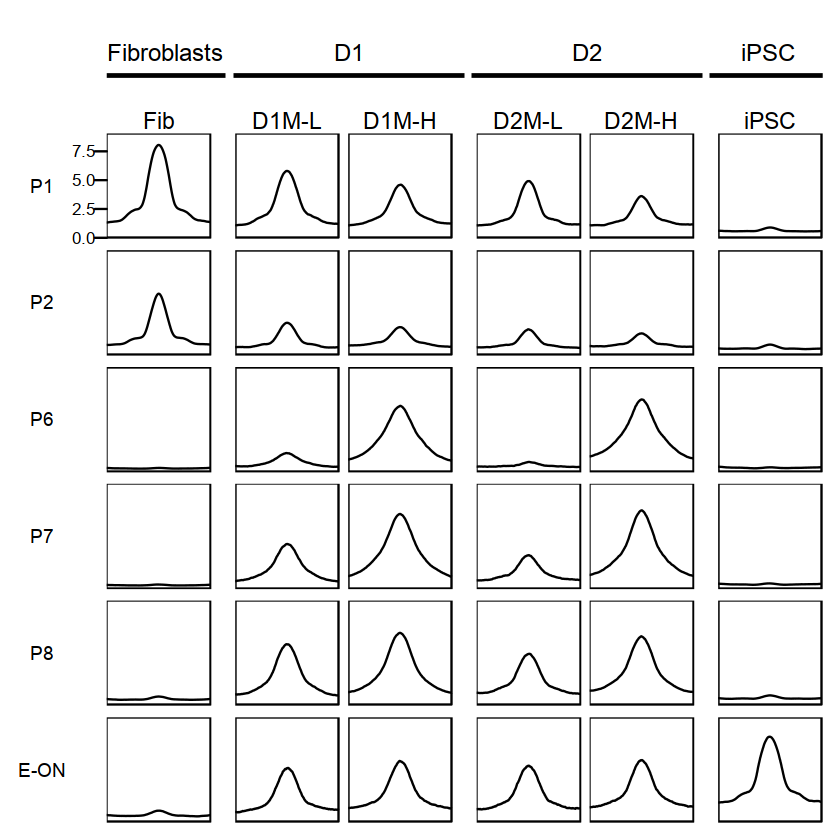

In [174]:
options(repr.plot.width = 7, repr.plot.height = 7)
vortex_grid = wrap_plots(
    rowwise_plots,
    ncol=1,
    heights = col_heights)

complete_plot = wrap_plots(top_annotate_plot,
                           vortex_grid,
                           heights=c(1, 8))
complete_plot

In [172]:
ggsave(sprintf("./subfigs/%s_pileup.pdf", format(Sys.Date(), "%Y%m%d")), 
       complete_plot, width=7,height=7)

In [ ]:
saveRDS(complete_plot, file=sprintf("./subfigs/%s_vortex.rds",
                                format(Sys.Date(), "%Y%m%d")))

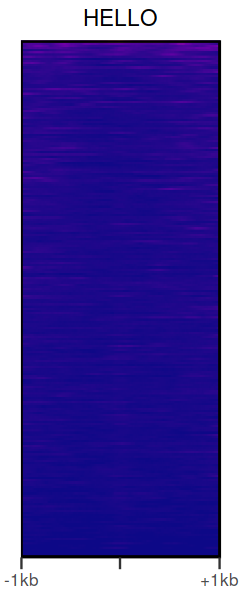

In [245]:
options(repr.plot.width = 2, repr.plot.height = 5)
plot_vortex(smoothed_matrices[[1]][[1]], 
            COLORSCALES[[as.numeric(vortex_config[1, "type"])]], 
            title="HELLO", ticks=1)